In [1]:
import pandas as pd
from siuba import *
from siuba.siu import call
from plotnine import *
import json
import matplotlib.pyplot as pp
import tidytext
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import datetime

import numpy as np

np.random.seed(500)

In [2]:
# load all the data
commits_raw = pd.read_pickle("../data/graphql/commits_total.pkl")
commits_df = pd.DataFrame()
for repo in commits_raw:
    commits_df = pd.concat([commits_df, pd.DataFrame(repo)])


In [3]:
issues_total = pd.read_pickle("../data/graphql/issues_total.pkl")
issuespr_total = pd.read_pickle("../data/graphql/issuespr_total.pkl")
issues_df = pd.concat((pd.DataFrame(issues_total), pd.DataFrame(issuespr_total)))


In [4]:
with open("../data/repos/topic_combined.json", "r") as read_file:
    raw = json.load(read_file)
repo_df = pd.DataFrame(raw)


# find relevant columns with correlation matricies

In [5]:
(repo_df
    >> distinct(_.id)
    >> count()
)

,n
0,1007


In [6]:
# select relevant columns
selected_df = (
    repo_df
    >> select(
        ~_.endswith("url"),
        ~_.homepage,
        ~_.size,
        ~_.web_commit_signoff_required,
        ~_.visibility,
        ~_.score,
        ~_.default_branch,
        ~_.permissions,
    )
    >> filter(_.private == False, _.archived == False, _.disabled == False)
    >> select(~_.archived, ~_.disabled)
)


In [7]:
selected_df.columns

Index(['id', 'node_id', 'name', 'full_name', 'private', 'owner', 'description',
       'fork', 'created_at', 'updated_at', 'pushed_at', 'stargazers_count',
       'watchers_count', 'language', 'has_issues', 'has_projects',
       'has_downloads', 'has_wiki', 'has_pages', 'has_discussions',
       'forks_count', 'open_issues_count', 'license', 'allow_forking',
       'is_template', 'topics', 'forks', 'open_issues', 'watchers'],
      dtype='object')

watchers == watchers_count == stargazers_count

forks == forks_count

issues == open_issues_count

forks_count <> stargazers_count == 0.851789 corr


In [8]:
(
    selected_df
    >> select(
        ~_.watchers,
        ~_.fork,
        ~_.watchers_count,
        _.stargazers_count,
        _.forks_count,
        ~_.forks,
        _.open_issues_count,
        ~_.open_issues,
        ~_.forks_count,
        ~_.private
    )
).corr()


/var/folders/5w/dhznpltj14n3nxr4fybjj8_w0000gn/T/ipykernel_81609/208152933.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,id,stargazers_count,has_issues,has_projects,has_downloads,has_wiki,has_pages,has_discussions,open_issues_count,allow_forking,is_template
id,1.000000,-0.289823,0.014164,0.063037,-0.006833,0.105566,-0.048536,-0.134018,-0.283314,NaN,0.011518
stargazers_count,-0.289823,1.000000,0.021781,-0.002645,0.005431,-0.092477,0.100473,0.172367,0.452322,NaN,-0.016101
has_issues,0.014164,0.021781,1.000000,0.419024,-0.004744,0.328706,-0.002435,0.034458,0.023713,NaN,-0.011656
has_projects,0.063037,-0.002645,0.419024,1.000000,-0.008671,0.721320,-0.032895,-0.053396,-0.012836,NaN,0.026851
has_downloads,-0.006833,0.005431,-0.004744,-0.008671,1.000000,0.089662,0.011830,0.011349,0.003604,NaN,0.005530
has_wiki,0.105566,-0.092477,0.328706,0.721320,0.089662,1.000000,-0.115052,-0.167513,-0.154708,NaN,-0.011668
has_pages,-0.048536,0.100473,-0.002435,-0.032895,0.011830,-0.115052,1.000000,0.222181,0.080330,NaN,-0.032382
has_discussions,-0.134018,0.172367,0.034458,-0.053396,0.011349,-0.167513,0.222181,1.000000,0.273247,NaN,0.024793
open_issues_count,-0.283314,0.452322,0.023713,-0.012836,0.003604,-0.154708,0.080330,0.273247,1.000000,NaN,-0.023169
allow_forking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
refined_df = (
    selected_df
    >> select(
        ~_.watchers,
        ~_.fork,
        ~_.watchers_count,
        _.stargazers_count,
        _.forks_count,
        ~_.forks,
        _.open_issues_count,
        ~_.open_issues,
        ~_.forks_count,
        ~_.private
    )
    >> filter(-_.description.isin([None]))
).drop_duplicates(subset='node_id')

In [10]:
len(refined_df)

949

https://github.com/orgs/community/discussions/24442
The difference is that pushed_at represents the date and time of the last commit, whereas the updated_at represents the date and time of the last change the the repository. A change to the repository might be a commit, but it may also be other things, such as changing the description of the repo, creating wiki pages

In [11]:
from siuba.experimental.datetime import floor_date, ceil_date
refined_df['created_at'] = refined_df.created_at.astype("datetime64[ns]")
refined_df['pushed_at'] = refined_df.pushed_at.astype("datetime64[ns]")
refined_df['language'] = refined_df.language.astype("category")
refined_df = (refined_df 

    >> mutate(
        age_days = (datetime.datetime(2023, 1, 21) - _.created_at).dt.components.days,
        time_since_last_commit_days = (datetime.datetime(2023, 1, 21) - _.pushed_at).dt.components.days
    )
    )

<AxesSubplot: >

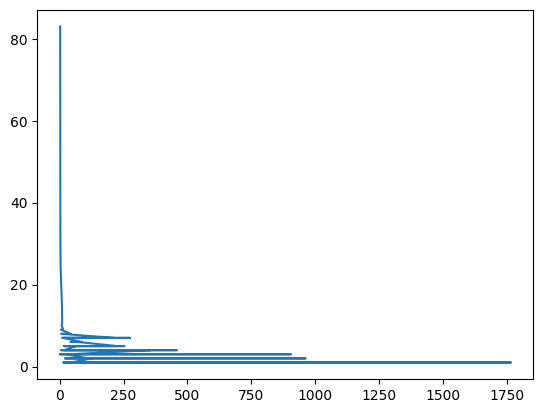

In [12]:
refined_df['time_since_last_commit_days'].value_counts().plot()

In [13]:
(refined_df
    >> arrange(-_.age_days)
    >> select(_.full_name, _.age_days))

,full_name,age_days
61,mlcommons/ck,2998
65,polyaxon/datatile,2492
21,weaviate/weaviate,2487
66,polyaxon/traceml,2441
103,VertaAI/modeldb,2284
...,...,...
196,terrytangyuan/awesome-kubeflow,11
847,YahyaGrb/mlflow_rasa_track,10
1007,prondos/ax-ml-ops,7
822,IAmRiteshKoushik/ML-for-Dummies,5


In [14]:
print ("age mean: ", refined_df.age_days.mean())
print("age median: ", refined_df.age_days.median())
print("age max: ", refined_df.age_days.max())

print ("stars mean: ", refined_df.stargazers_count.mean())
print("stars median: ", refined_df.stargazers_count.median())
print("stars max: ", refined_df.stargazers_count.max())

age mean:  564.3013698630137
age median:  485.0
age max:  2998
stars mean:  301.9378292939937
stars median:  4.0
stars max:  32107


In [15]:
(refined_df
    >> select(_.full_name, _.stargazers_count, _.node_id)
    >> arrange(-_.stargazers_count)
    >> head(20)

)

,full_name,stargazers_count,node_id
0,GokuMohandas/Made-With-ML,32107,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=
1,jina-ai/jina,17144,MDEwOlJlcG9zaXRvcnkyNDAzMTUwNDY=
100,mlflow/mlflow,13455,MDEwOlJlcG9zaXRvcnkxMzYyMDI2OTU=
2,EthicalML/awesome-production-machine-learning,13008,MDEwOlJlcG9zaXRvcnkxNDQ4NjM1MjU=
3,microsoft/nni,12415,MDEwOlJlcG9zaXRvcnkxMzU2NzM0NTE=
4,heartexlabs/label-studio,11747,MDEwOlJlcG9zaXRvcnkxOTI2NDA1Mjk=
5,visenger/awesome-mlops,9382,MDEwOlJlcG9zaXRvcnkyNDQ2MjAyNjk=
6,kedro-org/kedro,8013,MDEwOlJlcG9zaXRvcnkxODIwNjc1MDY=
7,great-expectations/great_expectations,7852,MDEwOlJlcG9zaXRvcnkxMDMwNzE1MjA=
8,aws/amazon-sagemaker-examples,7773,MDEwOlJlcG9zaXRvcnkxMDc5Mzc4MTU=


In [16]:
sum(refined_df.stargazers_count)

286539

In [17]:
(refined_df
    >> mutate(
        year = _.time_since_last_commit_days/365
    )
    >> filter(_.year >= 1)
)

,id,node_id,name,full_name,owner,description,created_at,updated_at,pushed_at,stargazers_count,...,has_pages,has_discussions,open_issues_count,license,allow_forking,is_template,topics,age_days,time_since_last_commit_days,year
74,375484255,MDEwOlJlcG9zaXRvcnkzNzU0ODQyNTU=,mlplatform-workshop,aporia-ai/mlplatform-workshop,"{'login': 'aporia-ai', 'id': 56439290, 'node_i...",🍫 Example code for a basic ML Platform based o...,2021-06-09 20:42:22,2023-01-11T08:46:26Z,2021-11-03 10:27:17,373,...,False,False,3,"{'key': 'mit', 'name': 'MIT License', 'spdx_id...",True,False,"[devops, machine-learning, mlops]",590,443,1.213699
106,280770443,MDEwOlJlcG9zaXRvcnkyODA3NzA0NDM=,klever,kleveross/klever,"{'login': 'kleveross', 'id': 68282154, 'node_i...",Cloud Native ML/DL Platform,2020-07-19 01:34:09,2022-11-20T12:05:40Z,2020-09-09 07:04:06,126,...,False,False,3,"{'key': 'apache-2.0', 'name': 'Apache License ...",True,False,"[ai-infra, cloud-native, deep-learning, kubefl...",915,863,2.364384
114,114361956,MDEwOlJlcG9zaXRvcnkxMTQzNjE5NTY=,lab,beringresearch/lab,"{'login': 'beringresearch', 'id': 14840322, 'n...",A lightweight command line interface for the m...,2017-12-15 11:09:17,2022-06-10T18:08:23Z,2021-01-29 06:25:55,18,...,False,False,0,"{'key': 'apache-2.0', 'name': 'Apache License ...",True,False,"[ai, machine-learning, ml, model-management, m...",1862,721,1.975342
123,269145497,MDEwOlJlcG9zaXRvcnkyNjkxNDU0OTc=,MMP-Frontend,IPVS-AS/MMP-Frontend,"{'login': 'IPVS-AS', 'id': 35486093, 'node_id'...",A Model Management Platform (MMP) for Industry...,2020-06-03 16:58:48,2022-11-10T08:17:16Z,2020-10-28 18:37:24,5,...,False,False,0,"{'key': 'other', 'name': 'Other', 'spdx_id': '...",True,False,"[industry-40, machine-learning, model-manageme...",961,814,2.230137
126,269140157,MDEwOlJlcG9zaXRvcnkyNjkxNDAxNTc=,MMP-Backend,IPVS-AS/MMP-Backend,"{'login': 'IPVS-AS', 'id': 35486093, 'node_id'...",A Model Management Platform (MMP) for Industry...,2020-06-03 16:33:23,2021-04-21T22:50:40Z,2020-06-04 08:18:50,3,...,False,False,0,"{'key': 'apache-2.0', 'name': 'Apache License ...",True,False,"[industry-40, machine-learning, model-manageme...",961,960,2.630137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1012,432638929,R_kgDOGcmL0Q,coursera-Machine-Learning-Engineering-for-Prod...,xia0nan/coursera-Machine-Learning-Engineering-...,"{'login': 'xia0nan', 'id': 2216266, 'node_id':...",Repo for Machine Learning Engineering for Prod...,2021-11-28 06:41:20,2021-11-29T01:19:27Z,2021-11-29 01:19:22,0,...,False,False,0,"{'key': 'mit', 'name': 'MIT License', 'spdx_id...",True,False,"[machine-learning, mlops]",418,417,1.142466
1019,270520128,MDEwOlJlcG9zaXRvcnkyNzA1MjAxMjg=,risk-models-for-medical-prognosis,hirenhk15/risk-models-for-medical-prognosis,"{'login': 'hirenhk15', 'id': 19776567, 'node_i...",An End-to-end Machine Learning System with Use...,2020-06-08 03:54:09,2022-03-14T09:10:15Z,2021-03-12 14:13:20,0,...,False,False,0,"{'key': 'mit', 'name': 'MIT License', 'spdx_id...",True,False,"[analytics, artificial-intelligence, data, dat...",956,679,1.860274
1023,394068528,MDEwOlJlcG9zaXRvcnkzOTQwNjg1Mjg=,CICD,vitorpbarbosa7/CICD,"{'login': 'vitorpbarbosa7', 'id': 57735093, 'n...",First contact with Docker,2021-08-08 20:58:07,2022-03-03T11:36:03Z,2021-08-09 00:47:25,0,...,False,False,0,None,True,False,"[container, docker, machine-learning, mlops]",530,529,1.449315
1025,286197790,MDEwOlJlcG9zaXRvcnkyODYxOTc3OTA=,trains-get-stats,shomratalon/trains-get-stats,"{'login': 'shomratalon', 'id': 14982269, 'node...",GitHub Action For Retrieving You Experiment Wi...,2020-08-09 08:31:45,2020-09-14T15:54:38Z,2020-09-14 15:54:36,0,...,False,False,0,"{'key': 'apache-2.0', 'name': 'Apache License ...",True,False,"[allegro-trains, deep-learning, machine-learni...",894,858,2.350685


/Users/isabelzimmerman/.pyenv/versions/pydemo/lib/python3.9/site-packages/plotnine/guides/guides.py:187: PlotnineWarning: Cannot generate legend for the 'alpha' aesthetic. Make sure you have mapped a variable to it


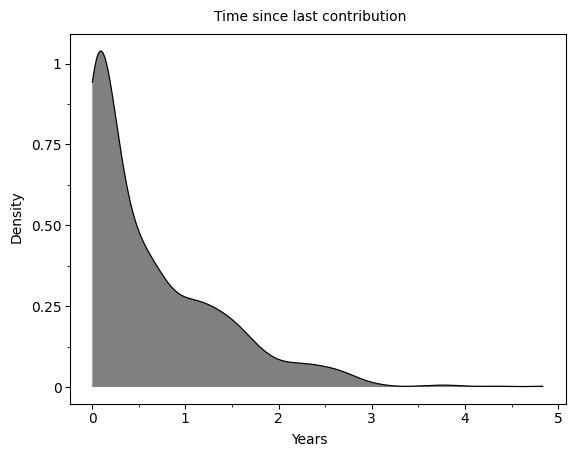

<ggplot: (841210468)>

In [18]:

(refined_df
    >> mutate(
        year = _.time_since_last_commit_days/365
    )
    >> ggplot(aes(x = 'year'))
       + geom_density(fill = 'grey')
       + theme_matplotlib()
       + scale_alpha_continuous(breaks = '0.5')
       + theme(
            # axis_title_y=element_blank(),
            # axis_text_y=element_blank(),
            # axis_ticks_minor_y=element_blank()

       )
       + labs(
        title = "Time since last contribution",
        x = "Years",
        y = "Density"
       )
)

In [19]:
refined_df.time_since_last_commit_days.median()

130.0

In [20]:
refined_df.time_since_last_commit_days.quantile([.25, .5, 0.75])

0.25     19.0
0.50    130.0
0.75    377.0
Name: time_since_last_commit_days, dtype: float64

<AxesSubplot: >

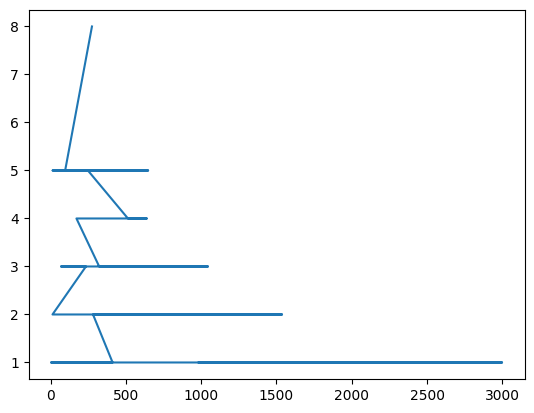

In [21]:
refined_df['age_days'].value_counts().plot()

In [24]:
lang = pd.DataFrame(
    refined_df.language.value_counts()
    .reset_index()
    .rename(columns={"index": "language", "language": "n"})
    .sort_values(by=['n'])
    .astype({'language': 'category'})
)

total_lang = sum(lang.n)

In [23]:
#board.pin_write(lang_percent, "lang", type="csv")

NameError: name 'board' is not defined

/Users/isabelzimmerman/.pyenv/versions/pydemo/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
/Users/isabelzimmerman/.pyenv/versions/pydemo/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide


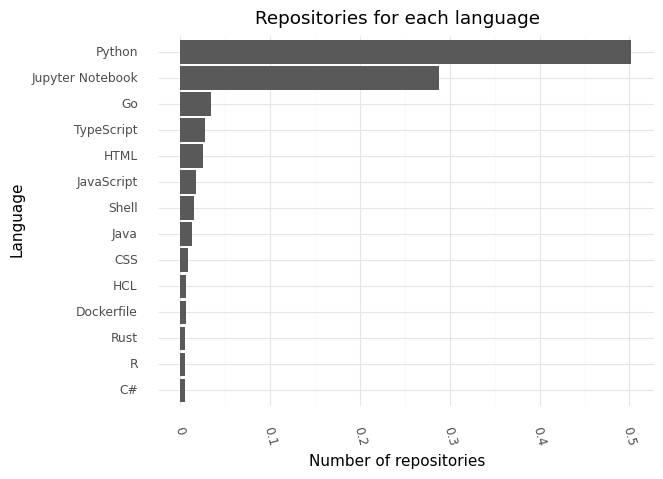

<ggplot: (854673143)>

In [32]:
(lang 
    >> filter(_.n >= 5)
    >> arrange(-_.n)
    >> mutate(
        percent = _.n/total_lang
    )
    >> ggplot()
        + geom_col(aes(x = 'reorder(language, percent)', y = "percent"))
        + labs(
            y = 'Number of repositories', 
            x = 'Language',
            title = 'Repositories for each language')
        + scale_y_continuous()
        + coord_flip()
        + theme_minimal()
        + theme(axis_text_x = element_text(angle = -75))

    )

# PCA for numeric data

In [ ]:
numeric_df = (refined_df
    >> select(_.stargazers_count,
    _.has_issues,
    _.has_projects,
    _.has_downloads,
    _.has_wiki,
    _.has_pages,
    _.has_discussions,
    _.open_issues_count,
    _.allow_forking,
    _.is_template,
    _.age_days,
    _.time_since_last_commit_days,
    _.description)
    )

numeric_df.columns

Index(['stargazers_count', 'has_issues', 'has_projects', 'has_downloads',
       'has_wiki', 'has_pages', 'has_discussions', 'open_issues_count',
       'allow_forking', 'is_template', 'age_days',
       'time_since_last_commit_days', 'description'],
      dtype='object')

In [ ]:
import pins

board = pins.board_folder(".")

len(board.pin_read("train_data"))

949

In [ ]:
import pins

board = pins.board_folder(".")

board.pin_write(numeric_df, "train_data", type='csv')

Writing pin:
Name: 'train_data'
Version: 20230417T233026Z-e7222


Meta(title='train_data: a pinned 949 x 13 DataFrame', description=None, created='20230417T233026Z', pin_hash='e72220ceddde1cfc', file='train_data.csv', file_size=135626, type='csv', api_version=1, version=Version(created=datetime.datetime(2023, 4, 17, 23, 30, 26, 798266), hash='e72220ceddde1cfc'), name='train_data', user={}, local={})

In [ ]:
numeric_df.corr()

,stargazers_count,has_issues,has_projects,has_downloads,has_wiki,has_pages,has_discussions,open_issues_count,allow_forking,is_template,age_days,time_since_last_commit_days
stargazers_count,1.000000,0.022014,0.011715,0.005487,-0.074236,0.103469,0.168364,0.444338,NaN,-0.015479,0.314891,-0.140544
has_issues,0.022014,1.000000,0.421496,-0.004924,0.331225,-0.001225,0.035929,0.024210,NaN,-0.011744,-0.043577,0.082498
has_projects,0.011715,0.421496,1.000000,-0.008943,0.721533,-0.032684,-0.053718,-0.001503,NaN,0.027023,-0.071287,0.140336
has_downloads,0.005487,-0.004924,-0.008943,1.000000,0.090379,0.012196,0.011691,0.003697,NaN,0.005644,0.009231,0.027611
has_wiki,-0.074236,0.331225,0.721533,0.090379,1.000000,-0.116943,-0.160682,-0.142623,NaN,-0.012872,-0.105632,0.185980
has_pages,0.103469,-0.001225,-0.032684,0.012196,-0.116943,1.000000,0.216514,0.081766,NaN,-0.032432,0.040193,-0.153579
has_discussions,0.168364,0.035929,-0.053718,0.011691,-0.160682,0.216514,1.000000,0.272607,NaN,0.026296,0.136109,-0.214098
open_issues_count,0.444338,0.024210,-0.001503,0.003697,-0.142623,0.081766,0.272607,1.000000,NaN,-0.022989,0.324104,-0.151425
allow_forking,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
is_template,-0.015479,-0.011744,0.027023,0.005644,-0.012872,-0.032432,0.026296,-0.022989,NaN,1.000000,-0.023220,-0.075741


# PCA of numeric repo data

## not scaled

In [ ]:
pca_numeric = PCA(n_components=2).fit(numeric_df)
pca_numeric_output = pca_numeric.transform(numeric_df)


In [ ]:
numeric_df.dtypes

stargazers_count               int64
has_issues                      bool
has_projects                    bool
has_downloads                   bool
has_wiki                        bool
has_pages                       bool
has_discussions                 bool
open_issues_count              int64
allow_forking                   bool
is_template                     bool
age_days                       int64
time_since_last_commit_days    int64
dtype: object

In [ ]:
pca_numeric.components_

array([[ 9.95783126e-01,  1.90231055e-06,  1.51537777e-06,
         1.08088645e-07, -1.47462294e-05,  2.12904286e-05,
         3.38724621e-05,  2.26738089e-02,  0.00000000e+00,
        -1.64106884e-06,  8.59427426e-02, -2.27092158e-02],
       [-7.49244672e-02, -1.14259322e-05, -2.71273552e-05,
         1.00932636e-06, -3.19559086e-05, -1.89731021e-05,
         3.01801733e-05,  3.11311337e-02, -0.00000000e+00,
        -1.40761332e-05,  9.44231553e-01,  3.19129985e-01]])

In [ ]:
# https://stackoverflow.com/questions/47370795/pca-on-sklearn-how-to-interpret-pca-components
# good PCA refresher https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e


def pca_plot(transformed_data, components):

    x = transformed_data[:, 0]
    y = transformed_data[:, 1]
    n = components.shape[0]

    plt.scatter(x, y)
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))
    plt.grid()
    
    for i in range(n):
        plt.arrow(0, 0, components[i, 0], components[i, 1], color="black", alpha=0.5)
        plt.text(
            components[i, 0] * 1.3,
            components[i, 1] * 1.3,
            "Var " + str(i + 1),
            color="black",
            ha="center",
            va="center",
        )

def most_important_feature(components, data):
    most_important = [np.abs(components[i]).argmax() for i in range(components.shape[0])]

    initial_feature_names = data.columns

    most_important_names = [initial_feature_names[most_important[i]] for i in range(components.shape[0])]

    dic = {'PC{}'.format(i): most_important_names[i] for i in range(components.shape[0])}


    return pd.DataFrame(dic.items())

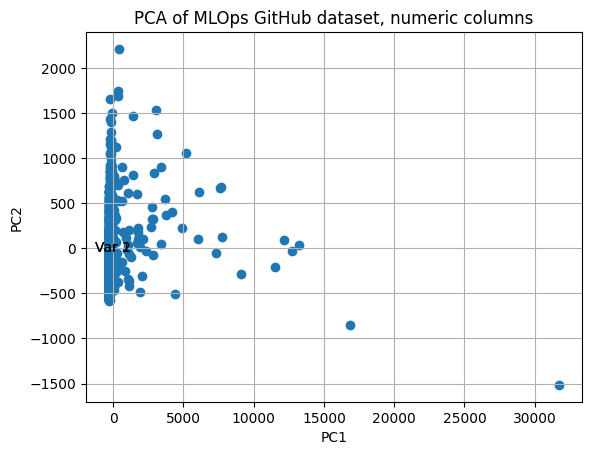

In [ ]:
plt.title("PCA of MLOps GitHub dataset, numeric columns")
pca_plot(pca_numeric_output, pca_numeric.components_) 
plt.show()

In [ ]:
most_important_feature(pca_numeric.components_, numeric_df)

,0,1
0,PC0,stargazers_count
1,PC1,age_days


## scaled

should i transform this data? feature scaling https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py

In [ ]:
scaled_numeric_df = StandardScaler().fit_transform(numeric_df)
pca_numeric_scaled = PCA(n_components=2).fit(scaled_numeric_df)
pca_numeric_scaled_output = pca_numeric_scaled.transform(scaled_numeric_df)

In [ ]:
numeric_df.columns

Index(['stargazers_count', 'has_issues', 'has_projects', 'has_downloads',
       'has_wiki', 'has_pages', 'has_discussions', 'open_issues_count',
       'allow_forking', 'is_template', 'age_days',
       'time_since_last_commit_days'],
      dtype='object')

what does this mean?

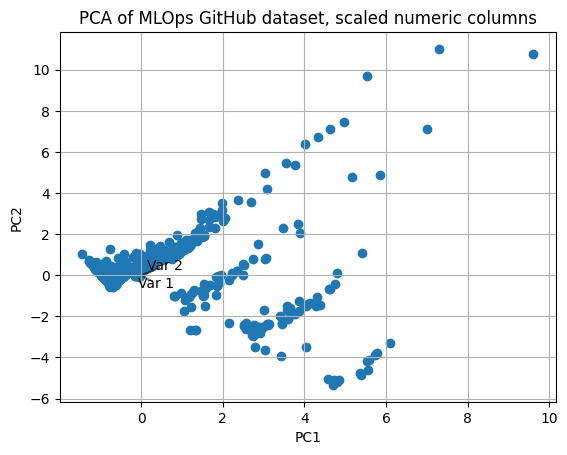

In [ ]:
plt.title("PCA of MLOps GitHub dataset, scaled numeric columns")

pca_plot(pca_numeric_scaled_output, pca_numeric_scaled.components_) 
plt.show()

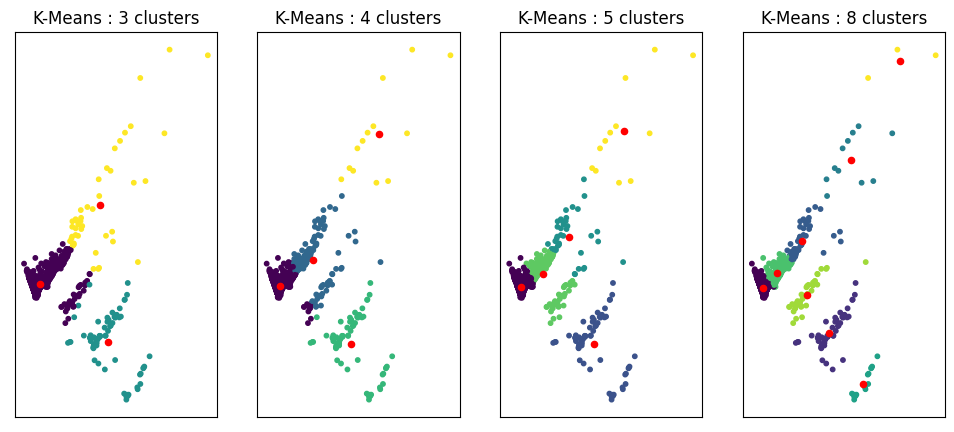

In [ ]:
# from https://scikit-learn.org/stable/auto_examples/cluster/plot_bisect_kmeans.html#sphx-glr-auto-examples-cluster-plot-bisect-kmeans-py
 
from sklearn.cluster import KMeans, DBSCAN
n_clusters_list = [3, 4, 5, 8]

clustering_algorithms = {
    "K-Means": KMeans,
}

# Make subplots for each variant
fig, axs = plt.subplots(
    len(clustering_algorithms), len(n_clusters_list), figsize=(12, 5)
)


for i, (algorithm_name, Algorithm) in enumerate(clustering_algorithms.items()):
    for j, n_clusters in enumerate(n_clusters_list):
        algo = Algorithm(n_clusters=n_clusters, random_state=500, n_init=3)
        algo.fit(pca_numeric_scaled_output)
        centers = algo.cluster_centers_

        axs[j].scatter(pca_numeric_scaled_output[:, 0], pca_numeric_scaled_output[:, 1], s=10, c=algo.labels_)
        axs[j].scatter(centers[:, 0], centers[:, 1], c="r", s=20)

        axs[j].set_title(f"{algorithm_name} : {n_clusters} clusters")


# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [ ]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps = 0.5, min_samples=5).fit(pca_numeric_scaled_output)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 5
Estimated number of noise points: 32


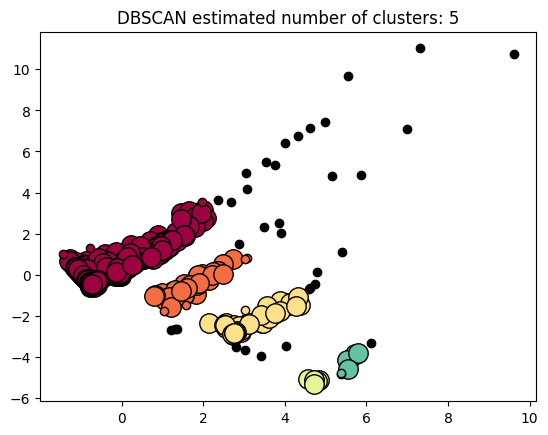

In [ ]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = pca_numeric_scaled_output[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = pca_numeric_scaled_output[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"DBSCAN estimated number of clusters: {n_clusters_}")
plt.show()

In [ ]:
numeric_df['pca_x'] = pca_numeric_scaled_output[:,0]
numeric_df['pca_y'] = pca_numeric_scaled_output[:,1]

In [ ]:
(numeric_df
    >> filter(_.pca_x < 0, _.pca_y < 0)
)

,stargazers_count,has_issues,has_projects,has_downloads,has_wiki,has_pages,has_discussions,open_issues_count,allow_forking,is_template,age_days,time_since_last_commit_days,pca_x,pca_y
70,398,True,True,True,True,False,False,2,True,False,238,2,-0.531758,-0.192959
71,396,True,True,True,True,False,False,1,True,False,136,81,-0.664739,-0.274867
77,357,True,True,True,True,False,False,3,True,False,430,88,-0.513025,-0.041034
93,240,True,True,True,True,False,False,40,True,False,261,2,-0.398149,-0.008217
117,11,True,True,True,True,False,False,1,True,False,275,45,-0.622603,-0.274088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1038,0,True,True,True,True,False,False,3,True,False,98,21,-0.688753,-0.407986
1039,0,True,True,True,True,False,False,0,True,False,31,31,-0.745678,-0.477094
1040,0,True,True,True,True,False,False,0,True,False,305,10,-0.579480,-0.261147
1041,0,True,True,True,True,False,False,0,True,False,231,4,-0.613402,-0.320219


In [ ]:
(numeric_df
    >> filter(_.pca_x > 1, _.pca_x < 2, _.pca_y < 0)
)

,stargazers_count,has_issues,has_projects,has_downloads,has_wiki,has_pages,has_discussions,open_issues_count,allow_forking,is_template,age_days,time_since_last_commit_days,pca_x,pca_y
56,677,True,False,True,True,False,False,130,True,False,276,2,1.822870,-0.943839
91,242,True,True,True,False,False,False,18,True,False,548,83,1.258243,-0.812920
162,127,True,True,True,False,False,False,13,True,False,470,44,1.213945,-0.936983
196,79,True,True,True,False,True,False,0,True,False,11,9,1.528874,-0.978110
198,78,True,True,True,False,False,True,10,True,False,485,326,1.835465,-0.089116
208,72,True,False,True,True,False,False,0,True,False,345,224,1.039869,-1.763245
222,55,True,True,True,False,False,False,16,True,False,121,2,1.066207,-1.219881
227,54,True,True,True,False,False,False,5,True,False,378,8,1.154828,-1.076884
291,25,True,True,True,False,True,False,4,True,False,668,379,1.538900,-0.426156
299,23,True,True,True,False,False,False,72,True,False,1246,2,1.880799,-0.026428


In [ ]:
most_important_feature(pca_numeric_scaled.components_, numeric_df)

,0,1
0,PC0,has_wiki
1,PC1,open_issues_count


## what about the self labeled topics at the repo level?

In [ ]:
refined_df.topics.iloc[0]

['data-engineering',
 'data-science',
 'deep-learning',
 'machine-learning',
 'mlops',
 'natural-language-processing',
 'python',
 'pytorch']

In [ ]:
from collections import Counter

all_topics = (
    pd.DataFrame.from_dict(Counter(refined_df.topics.sum()), orient="index")
    .reset_index()
    .rename(columns={"index": "topics", 0: "n"})
)


In [ ]:
(all_topics
    >> arrange(-_.n)
)

,topics,n
4,mlops,938
3,machine-learning,512
6,python,237
1,data-science,195
2,deep-learning,169
...,...,...
1739,full-stack,1
1740,plant,1
1741,plantdiseasedetection,1
1742,web,1


In [ ]:
(all_topics
    >> filter(_.n > 1)
    >> count()
)

,n
0,610


In [ ]:
all_topics['topics'] = all_topics.topics.str.replace("-", " ")
all_topics

,topics,n
0,data engineering,30
1,data science,195
2,deep learning,169
3,machine learning,512
4,mlops,938
...,...,...
1739,full stack,1
1740,plant,1
1741,plantdiseasedetection,1
1742,web,1


## what about licenses?

In [ ]:
refined_df['license'] = refined_df.license.apply(pd.Series, dtype = 'object').key

In [ ]:
refined_df.license.astype("category")

0              mit
1       apache-2.0
2              mit
3              mit
4       apache-2.0
           ...    
1039           NaN
1040           NaN
1041           NaN
1042           mit
1043           mit
Name: license, Length: 986, dtype: category
Categories (13, object): ['agpl-3.0', 'apache-2.0', 'bsd-2-clause', 'bsd-3-clause', ..., 'mit', 'mit-0', 'mpl-2.0', 'other']

In [ ]:
refined_df

,id,node_id,name,full_name,owner,description,created_at,updated_at,pushed_at,stargazers_count,...,has_wiki,has_pages,has_discussions,open_issues_count,license,allow_forking,is_template,topics,age_days,time_since_last_commit_days
0,156157055,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,Made-With-ML,GokuMohandas/Made-With-ML,"{'login': 'GokuMohandas', 'id': 8000987, 'node...","Learn how to responsibly develop, deploy and m...",2018-11-05 03:44:27,2023-01-18T14:24:54Z,2022-11-08 13:52:44,32107,...,True,False,False,6,mit,True,False,"[data-engineering, data-science, deep-learning...",1537,73
1,240315046,MDEwOlJlcG9zaXRvcnkyNDAzMTUwNDY=,jina,jina-ai/jina,"{'login': 'jina-ai', 'id': 60539444, 'node_id'...",🔮 Build multimodal AI services via cloud nativ...,2020-02-13 17:04:44,2023-01-18T14:18:14Z,2023-01-18 16:21:18,17144,...,False,True,False,33,apache-2.0,True,False,"[aiops, airflow, cloud-native, creative-ai, cr...",1072,2
2,144863525,MDEwOlJlcG9zaXRvcnkxNDQ4NjM1MjU=,awesome-production-machine-learning,EthicalML/awesome-production-machine-learning,"{'login': 'EthicalML', 'id': 43532924, 'node_i...",A curated list of awesome open source librarie...,2018-08-15 14:28:41,2023-01-18T17:16:27Z,2023-01-16 06:42:25,13008,...,True,True,False,26,mit,True,False,"[awesome, awesome-list, data-mining, deep-lear...",1619,4
3,135673451,MDEwOlJlcG9zaXRvcnkxMzU2NzM0NTE=,nni,microsoft/nni,"{'login': 'microsoft', 'id': 6154722, 'node_id...",An open source AutoML toolkit for automate mac...,2018-06-01 05:51:44,2023-01-18T12:49:05Z,2023-01-18 09:27:55,12415,...,True,False,True,290,mit,True,False,"[automated-machine-learning, automl, bayesian-...",1694,2
4,192640529,MDEwOlJlcG9zaXRvcnkxOTI2NDA1Mjk=,label-studio,heartexlabs/label-studio,"{'login': 'heartexlabs', 'id': 48309720, 'node...",Label Studio is a multi-type data labeling and...,2019-06-19 02:00:44,2023-01-18T11:31:18Z,2023-01-18 17:09:25,11747,...,True,False,True,448,apache-2.0,True,False,"[annotation, annotation-tool, annotations, bou...",1311,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1039,580399205,R_kgDOIpgwZQ,step-functions-sagemaker-ml-pipeline,hkford/step-functions-sagemaker-ml-pipeline,"{'login': 'hkford', 'id': 82389275, 'node_id':...",ML pipeline with AWS Step Functions and Amazon...,2022-12-20 13:17:41,2022-12-20T13:33:21Z,2022-12-20 13:32:14,0,...,True,False,False,0,NaN,True,False,"[mlops, sagemaker, step-functions]",31,31
1040,472158586,R_kgDOHCSReg,genome,edeliu2000/genome,"{'login': 'edeliu2000', 'id': 8235794, 'node_i...",AI AutoML Platform Services for Managing Milli...,2022-03-21 02:18:15,2022-12-09T17:27:37Z,2023-01-10 23:03:03,0,...,True,False,False,0,NaN,True,False,"[automlops, configurable-ai, controllable-ai, ...",305,10
1041,499422453,R_kgDOHcSU9Q,ml-ops,khoaguin/ml-ops,"{'login': 'khoaguin', 'id': 88959106, 'node_id...",A Learning Journal on Machine Learning in Prod...,2022-06-03 07:38:42,2022-06-10T08:40:17Z,2023-01-16 07:24:02,0,...,True,False,False,0,NaN,True,False,[mlops],231,4
1042,575407571,R_kgDOIkwF0w,Plant-disease-Detection,shashank1623/Plant-disease-Detection,"{'login': 'shashank1623', 'id': 86946068, 'nod...",Plant Disease Detection using convolutional n...,2022-12-07 12:53:33,2023-01-10T17:25:44Z,2023-01-10 17:29:52,0,...,True,False,False,0,mit,True,False,"[adam-optimizer, cnn, d, deep-learning, develo...",44,10


## what do we know about the PRs?

In [ ]:
prs_df = pd.DataFrame(issuespr_total)
prs_df.head()


,id,milestone_id,repository_id,user_id,body,closed_at,created_at,locked,number,state,title,updated_at,type
0,MDExOlB1bGxSZXF1ZXN0MjI4NDQ0MTI4,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjgwMDA5ODc=,,2018-11-05T18:20:05Z,2018-11-05T18:14:37Z,False,1,MERGED,added instructions for running and contributin...,2018-11-05T18:20:05Z,PullRequest
1,MDExOlB1bGxSZXF1ZXN0MjI4NDQ2MDM3,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjgwMDA5ODc=,,2018-11-05T18:21:46Z,2018-11-05T18:21:38Z,False,2,MERGED,fixed upload image link,2018-11-05T18:21:46Z,PullRequest
2,MDExOlB1bGxSZXF1ZXN0MjI4NDU3Mjg4,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjgwMDA5ODc=,,2018-11-05T19:02:46Z,2018-11-05T19:02:25Z,False,3,MERGED,made readme more readable by adding linebreaks,2018-11-05T19:02:46Z,PullRequest
3,MDExOlB1bGxSZXF1ZXN0MjI4NDU3ODMy,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjgwMDA5ODc=,,2018-11-05T19:04:31Z,2018-11-05T19:04:24Z,False,4,MERGED,fixed contribution instructions,2018-11-05T19:04:32Z,PullRequest
4,MDExOlB1bGxSZXF1ZXN0MjI4NDU4NTc0,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjgwMDA5ODc=,,2018-11-05T19:07:24Z,2018-11-05T19:07:17Z,False,5,MERGED,fixed contributing instructions,2018-11-05T20:47:30Z,PullRequest


In [ ]:
(prs_df
    >> distinct(_.type))

,type
0,PullRequest


In [ ]:
(prs_df
    >> count(_.repository_id)
    >> arrange(-_.n))

,repository_id,n
19,MDEwOlJlcG9zaXRvcnkxMzE2MTk2NDY=,6589
36,MDEwOlJlcG9zaXRvcnkxNzI4MjIxOTU=,6478
21,MDEwOlJlcG9zaXRvcnkxMzMxMDA4ODA=,5604
90,MDEwOlJlcG9zaXRvcnkyNTM4NDY4Nzk=,5572
11,MDEwOlJlcG9zaXRvcnkxMDMwNzE1MjA=,5320
...,...,...
267,R_kgDOGxQ4Bg,1
286,R_kgDOHJgXCw,1
293,R_kgDOHTLodQ,1
305,R_kgDOHhZcuw,1


In [ ]:
users_issues = issues_df >> select(_.user_id) >> distinct()
users_prs = prs_df >> select(_.user_id) >> distinct()

print(f'issues: {len(users_issues)}')
print(f'prs: {len(users_prs)}')

issues: 17649
prs: 7373


In [ ]:
(pd.concat([users_issues, users_prs])
    >> distinct()
)

,user_id
0,MDQ6VXNlcjExNTMwMjQ3
1,MDQ6VXNlcjIyOTU5MDM3
2,MDQ6VXNlcjI3MTQzMDU4
3,MDQ6VXNlcjcwMDYxNw==
4,MDQ6VXNlcjExNTU1NzM=
...,...
17644,MDQ6VXNlcjM3NTczNjI5
17645,U_kgDOBt1LjA
17646,U_kgDOBZf1Ng
17647,MDQ6VXNlcjY0NDg3MDM4


In [ ]:
assert len(prs_df.columns) == len(issues_df.columns)

In [ ]:
combine_issues_prs = pd.concat([issues_df, prs_df])

In [ ]:
(combine_issues_prs
    >> distinct(_.repository_id)
)

,repository_id
0,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=
1,MDEwOlJlcG9zaXRvcnkyNDAzMTUwNDY=
2,MDEwOlJlcG9zaXRvcnkxNDQ4NjM1MjU=
3,MDEwOlJlcG9zaXRvcnkxMzU2NzM0NTE=
4,MDEwOlJlcG9zaXRvcnkxOTI2NDA1Mjk=
...,...
358,R_kgDOHj3zDw
359,MDEwOlJlcG9zaXRvcnk0MDIzMDY2NzE=
360,R_kgDOHozdZg
361,R_kgDOH9bggw


In [ ]:
from siuba.dply.vector import n_distinct
(prs_df
    >> select(_.repository_id, _.user_id)
    >> distinct()
    >> group_by(_.repository_id)
    >> mutate(n_pr_makers = n_distinct(_.user_id))
    >> ungroup()
    >> select(_.repository_id, _.n_pr_makers)
    >> distinct()
    >> arrange(-_.n_pr_makers)
)

,repository_id,n_pr_makers
85,MDEwOlJlcG9zaXRvcnkxMzYyMDI2OTU=,725
8,MDEwOlJlcG9zaXRvcnkxMDc5Mzc4MTU=,565
23,MDEwOlJlcG9zaXRvcnkxMzMxMDA4ODA=,434
7,MDEwOlJlcG9zaXRvcnkxMDMwNzE1MjA=,398
11,MDEwOlJlcG9zaXRvcnkxMzE2MTk2NDY=,303
...,...,...
327,R_kgDOHJgXCw,1
328,R_kgDOHozdZg,1
329,R_kgDOH9bggw,1
331,MDEwOlJlcG9zaXRvcnkzODk0MzQwOTA=,1


In [ ]:
len(prs_df
    >> distinct(_.repository_id)
)

333

In [ ]:
prs_df['created_at'] = prs_df.created_at.astype("datetime64[ns]")
# MLFLOW
# (prs_df
#     >> mutate(
#         month = _.created_at.dt.month,
#         year = _.created_at.dt.year
#     )
#     >> group_by(_.repository_id, _.month, _.year)
#     >> count(_.month, _.year)
#     >> filter(_.repository_id == 'MDEwOlJlcG9zaXRvcnkxMzYyMDI2OTU=')
#     >> arrange(_.year, _.month)
# )

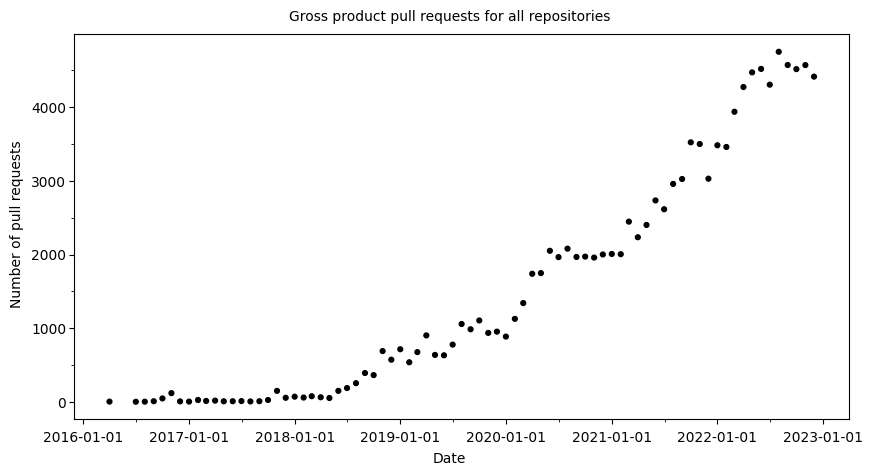

<ggplot: (850556356)>

In [ ]:
(prs_df
    >> mutate(
        year_month = _.created_at.dt.strftime('%Y-%m')
    )
    >> filter(_.year_month < '2023-01')
    >> count(_.year_month)
    >> ggplot(aes(x = 'year_month', y = 'n'))
        + geom_point()
        + labs(x='Date', y='Number of pull requests')
        + scale_x_date(date_breaks = '1 year')
        + theme_matplotlib()
        + theme(
            figure_size=(10,5),
            axis_text_x=element_text(margin={'t': 5, 'r': 5})
        )
        + labs(
            title="Gross product pull requests for all repositories"
        )
)

In [ ]:
refined_df >> filter(_.full_name == 'mlflow/mlflow')

,id,node_id,name,full_name,owner,description,created_at,updated_at,pushed_at,stargazers_count,...,has_wiki,has_pages,has_discussions,open_issues_count,license,allow_forking,is_template,topics,age_days,time_since_last_commit_days
100,136202695,MDEwOlJlcG9zaXRvcnkxMzYyMDI2OTU=,mlflow,mlflow/mlflow,"{'login': 'mlflow', 'id': 39938107, 'node_id':...",Open source platform for the machine learning ...,2018-06-05 16:05:58,2023-01-18T18:35:07Z,2023-01-19 00:47:53,13455,...,True,False,True,1008,apache-2.0,True,False,"[ai, apache-spark, machine-learning, ml, mlflo...",1690,1


In [ ]:
len(prs_df)

121704

In [ ]:
(prs_df  
    >> filter(_.state == 'MERGED')
    >> count()
)

,n
0,100836


In [ ]:
prs_small = (prs_df
    >> filter(_.state == 'MERGED')
    >> select(_.repository_id, _.title)
)

In [ ]:
from sklearn.feature_extraction import text

additional_stopwords = frozenset({
    "readme",
    "md",
    "update",
    "fix",
    "fixing",
    "fixes",
    "docs",
    "add",
    "updated",
    "feat",
    "page",
    "typo",
    "ci",
    "cd",
    "github",
    "chore",
    "tests",
    "test",
    "feature",
    "updates",
    "links",
    "merge",
    "dev",
    "broken",
    "example",
    "cli",
    "update",
    "deps",
    "migration",
    "lint",
    "setup",
    "link",
    "update",
    "error",
    "message",
    "remove",
    "deps",
    "update",
    "dependency",
    "dependencies",
    "requirements",
    "chore",
    "v1",
    "components",
    "merge",
    "0",
    "1",
    "bump",
    "2",
    "3",
    "release",
    "version",
    "v0",
    "build",
    "support",
    "refactor",
    "type",
    "types",
    "coverage",
    "master",
    "main",
    "branch",
    "clean",
    "documentation",
    "testing"
})

stop_words = text.ENGLISH_STOP_WORDS.union(additional_stopwords)


In [ ]:
# copied from 03_clean_text.ipynb
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
tokenizer = RegexpTokenizer(r'\w+')

pr_sents  = prs_small.title.to_list()
# Vectorize document using TF-IDF
pr_tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stop_words,
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
pr_train_data = pr_tfidf.fit_transform(pr_sents)   
# Define the number of topics or components
num_components=5

# Create LDA object
pr_model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
pr_lda_matrix = pr_model.fit_transform(pr_train_data)

# Get Components 
pr_lda_components=pr_model.components_

In [ ]:
# Print the topics with their terms
pr_terms = pr_tfidf.get_feature_names_out()

for index, component in enumerate(pr_lda_components):
    zipped = zip(pr_terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['7', 'doc', 'python', 'examples', 'actions', 'maintenance', 'model']
Topic 1:  ['5', '4', '6', 'docker', '9', 'commit', 'sdk']
Topic 2:  ['eslint', 'plugin', 'cleanup', 'monorepo', 'spark', 'v4', 'v5']
Topic 3:  ['changelog', 'mlflow', 'helm', 'sample', 'small', 'added', 'use']
Topic 4:  ['api', 'run', 'make', 'integration', 'dagit', 'model', 'sdk']


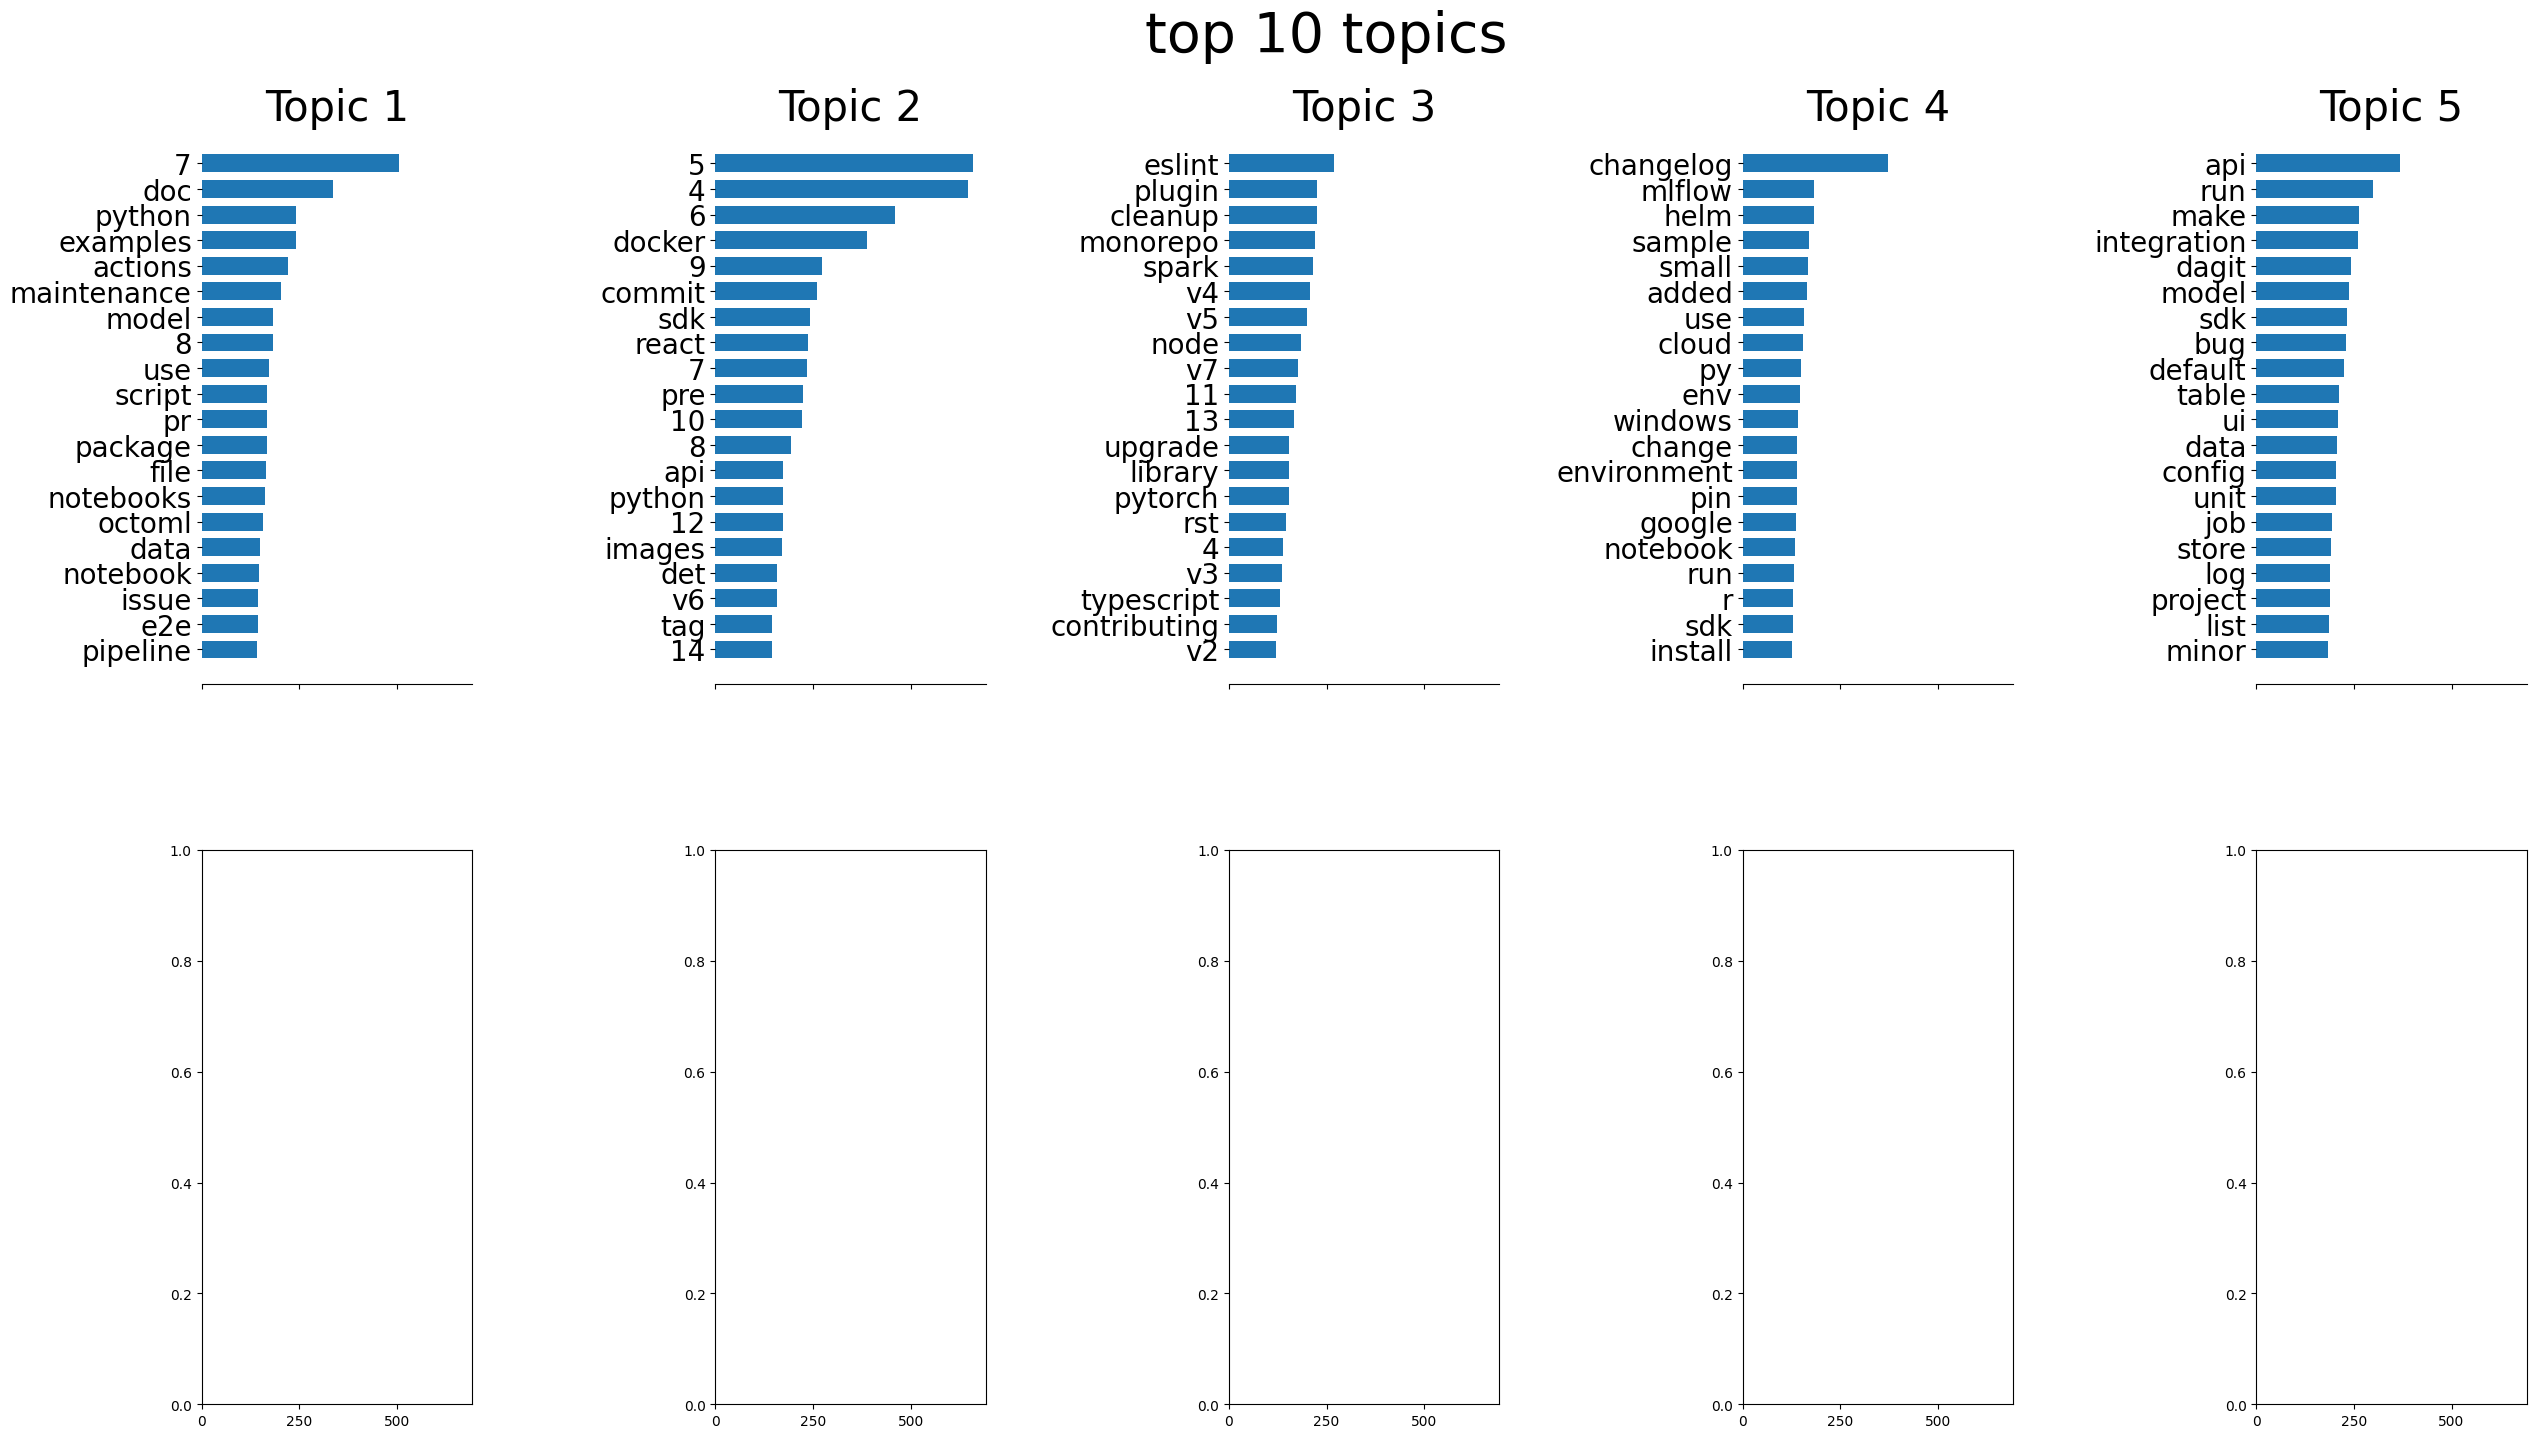

In [ ]:
import matplotlib.pyplot as plt

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(pr_model, pr_tfidf.get_feature_names_out(), 20, "top 10 topics")

okay, so all the topics are around maintainance, not necessarily features or mlops-y tasks. this is pretty expected

## what about issues?

looking at issues titles, not body

In [ ]:
issues_df = pd.DataFrame(issues_total)
issues_df.head()

,id,milestone_id,repository_id,user_id,body,closed_at,created_at,locked,number,state,title,updated_at,type
0,MDU6SXNzdWUzODk2NzE0MDM=,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjExNTMwMjQ3,Great repo!\r\nCan i translate it to Chinese?,2018-12-11T11:14:53Z,2018-12-11T09:37:03Z,False,69,CLOSED,Chinese translation,2022-09-16T08:27:39Z,Issue
1,MDU6SXNzdWUzOTA0OTEwMzg=,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjIyOTU5MDM3,Is it okay to contribute to segmentation part ...,2018-12-13T16:22:16Z,2018-12-13T02:25:32Z,False,76,CLOSED,Contribution to Computer Vision?,2018-12-13T16:22:16Z,Issue
2,MDU6SXNzdWUzOTA1NDQ4OTM=,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjI3MTQzMDU4,Could u pls release a instruction on Jupyter n...,2018-12-13T13:33:46Z,2018-12-13T07:05:19Z,False,78,CLOSED,Notebook,2018-12-13T13:33:46Z,Issue
3,MDU6SXNzdWUzOTA3NDQ3OTQ=,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjcwMDYxNw==,In the [numpy notebook](https://github.com/Gok...,2018-12-13T16:22:02Z,2018-12-13T16:00:06Z,False,83,CLOSED,3d or 2d numpy array?,2018-12-13T16:22:02Z,Issue
4,MDU6SXNzdWUzOTI3NTY3OTc=,None,MDEwOlJlcG9zaXRvcnkxNTYxNTcwNTU=,MDQ6VXNlcjExNTU1NzM=,"Hi @GokuMohandas,\r\n\r\nI've been recently ta...",2018-12-25T20:42:17Z,2018-12-19T20:02:14Z,False,90,CLOSED,Alternative to Colab and Binder for running `p...,2018-12-26T15:44:03Z,Issue


In [ ]:
len(issues_df)

55994

In [ ]:
issues_sents  = issues_df.title.to_list()
# Vectorize document using TF-IDF
issues_tfidf = TfidfVectorizer(lowercase=True,
                        stop_words=stop_words,
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transform the documents
issues_train_data = issues_tfidf.fit_transform(pr_sents)   
# Define the number of topics or components
num_components=5

# Create LDA object
issues_model=LatentDirichletAllocation(n_components=num_components)

# Fit and Transform SVD model on data
issues_lda_matrix = issues_model.fit_transform(pr_train_data)

# Get Components 
issues_lda_components = issues_model.components_

In [ ]:
# Print the topics with their terms
issues_terms = issues_tfidf.get_feature_names_out()

for index, component in enumerate(issues_lda_components):
    zipped = zip(issues_terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:7]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['7', 'commit', 'pre', 'pytorch', 'sdk', 'examples', 'helm']
Topic 1:  ['pipeline', 'api', 'det', 'use', 'sdk', 'node', 'default']
Topic 2:  ['changelog', 'react', 'minor', 'plugin', 'eslint', 'v3', 'module']
Topic 3:  ['4', '5', '6', 'python', '8', 'docker', 'monorepo']
Topic 4:  ['doc', 'run', 'config', 'ui', 'api', 'store', 'command']


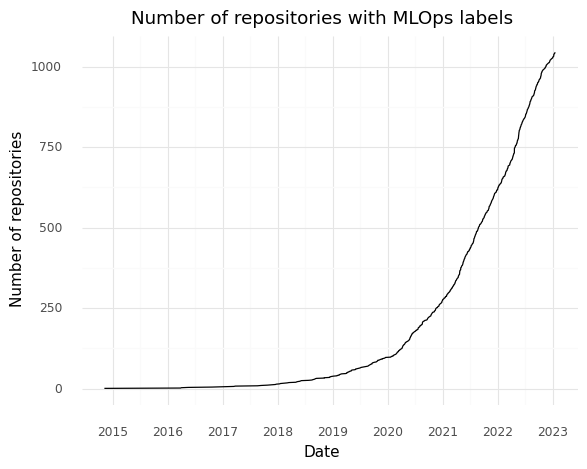

<ggplot: (874157421)>

In [ ]:
from mizani.breaks import date_breaks
from mizani.formatters import date_format
(repo_df
    >> select(_.created_at)
    >> mutate(
        created_at = _.created_at.astype("datetime64[ns]"),
        n = 1
    )
    >> arrange(_.created_at)
    >> mutate(
        n_cumsum = _.n.cumsum()
    )
    >> ggplot()
        + geom_line(aes('created_at', 'n_cumsum'))
        + scale_x_datetime(breaks=date_breaks('1 year'), labels=date_format('%Y'))     # modified
        + labs(
            x = 'Date',
            y= 'Number of repositories',
            title = 'Number of repositories with MLOps labels')
        + theme_minimal()

)